In [15]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [40]:
import plotly.graph_objs as go
import cufflinks as cf
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

from PortfolioAnalyser import PortfolioAnalyser as pa
from pandas_datareader import data as pdr

yf.pdr_override()

pd.options.display.float_format = '{:,.4f}'.format

**Function objective:** Make rolling yearly returns given a dataframe of stock quotes and the number of years to apply in the computation. The financial industry uses 252 session in a year and i find that an unnecessary simplification and a lots of time wrong. Made this funtion to use years as showned below.  

**Inputs:** 
- Quotes dataframe;
- Number of years.

**Outputs**
- Time series of rolling CAGR in the number of years given for computation (HPR is used in case of one year).

Let's download some data for the SPY etf to show the calculations:

In [3]:
%%capture
tickers = ['SPY']
Quotes  = pd.DataFrame()
Start   = "2008-12-01"
End     = "2020-01-05"

for ticker in tickers:
    Quotes[ticker] = pdr.get_data_yahoo(ticker, start=Start, end=End)['Adj Close']

In [4]:
Quotes.head(3)

,SPY
Date,
2008-12-01,65.1800
2008-12-02,67.6900
2008-12-03,69.3100


In [5]:
Quotes.tail(3)

,SPY
Date,
2019-12-31,321.8600
2020-01-02,324.8700
2020-01-03,322.4100


In [2]:
def cumulative_sessions_return(df, years, sessions_per_year):
    shifted = df.shift(sessions_per_year * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)
    return One_year

Time to compute the 252 session rolling return (CSR):

In [6]:
%%time
CSR = cumulative_sessions_return(Quotes, years=1, sessions_per_year=252)
CSR.columns = ['CSR']

Wall time: 33 ms


Time to compute the year rolling return function (CRR):

In [7]:
%%time
CRR = pa.compute_rolling_cagr(Quotes, years=1)
CRR.columns = ['CRR']

Wall time: 15.5 s


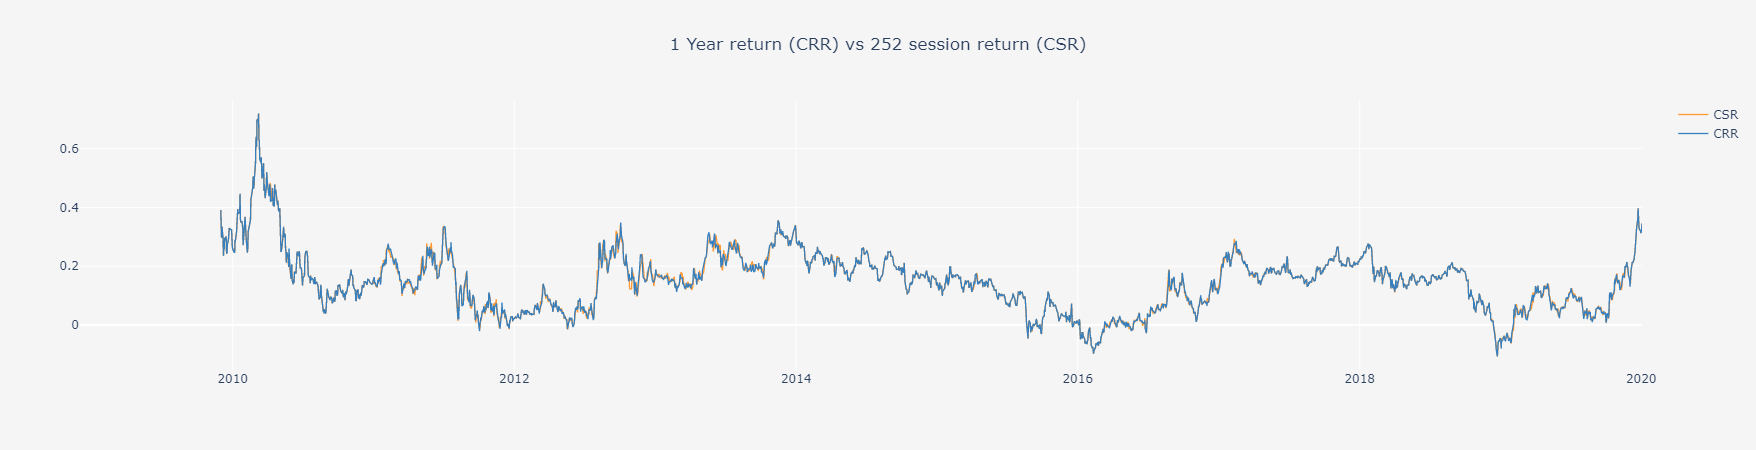

In [55]:
layout = go.Layout(
    title ='1 Year return (CRR) vs 252 session return (CSR)',
    paper_bgcolor ='rgb(245, 245, 245)',
    plot_bgcolor ='rgb(245, 245, 245)',
    hovermode = 'x',
    title_x = 0.5,    
      )

Returns = pa.merge_time_series(CSR, CRR)
Returns.iplot(layout=layout.to_plotly_json())

    - CSR: Cumulative Sessions Return - Return over 252 sessions;
    - CRR: Compute Rolling CAGR - Uses human years for calculation.

There are some differences in using the industry standard 252 sessions and the compute_rolling_cagr() function. Let's see days were they were different and see what was correct:

#### First date: 2012-10-26

In [9]:
pd.DataFrame(Returns.loc['2012-10-26']).transpose()

,CSR,CRR
2012-10-26,0.1225,0.1615


There's a big disparity in this day. 12.25% for the 252 session return vs 16.15% in the compute_rolling_cagr() one year return. Let's see what happened:

Quote of SPY on 2012-10-26

In [10]:
pd.DataFrame(Quotes.loc['2012-10-26']).transpose()

,SPY
2012-10-26,122.2800


Quote of SPY on 2011-10-26

In [11]:
pd.DataFrame(Quotes.loc['2011-10-26']).transpose()

,SPY
2011-10-26,105.2800


Let's divide one by the other and subtract one to get the HPR of this period/year:

```python
(122.28 / 105.28) - 1 =
```

In [12]:
round((Quotes.loc['2012-10-26'] / Quotes.loc['2011-10-26'] - 1)[0], 4)

0.1615

It seems like the CRR function is correct. This was a simple example where there was quotes to the day on both years. Next we show an example where that's not the case:

In [13]:
pd.DataFrame(Returns.loc['2011-05-31']).transpose()

,CSR,CRR
2011-05-31,0.2795,0.2580


In [14]:
pd.DataFrame(Quotes.loc['2011-05-31']).transpose()

,SPY
2011-05-31,113.1100


There is no quote for SPY on 2010-05-31, so we cant' make a "clean" 365 days return. You should use the previous quote instead. That's the 2010-05-28 quote.

In [15]:
Quotes.loc['2010-05-27':].head()

,SPY
Date,
2010-05-27,91.0600
2010-05-28,89.9100
2010-06-01,88.4000
2010-06-02,90.7000
2010-06-03,91.0200


Let's divide one by the other and subtract one to get the HPR of this period/year:

```python
(113.11 / 89.91) - 1 = 
```

In [16]:
round((Quotes.loc['2011-05-31'] / Quotes.loc['2010-05-28'] - 1)[0], 4)

0.258

Finally let's test specifically in a leap year on 29 of February.

In [17]:
pd.DataFrame(Returns.loc['2012-02-29']).transpose()

,CSR,CRR
2012-02-29,0.0685,0.0506


In [18]:
pd.DataFrame(Quotes.loc['2012-02-29']).transpose()

,SPY
2012-02-29,116.7900


In [19]:
Quotes.loc['2011-02-27':].head()

,SPY
Date,
2011-02-28,111.1600
2011-03-01,109.3000
2011-03-02,109.5400
2011-03-03,111.4200
2011-03-04,110.5900


Since there is no 2011-02-29, we must use the quote from 2011-02-28. Let's divide one by the other and subtract one to get the HPR of this period/year:

```python
(116.79 / 111.16) - 1 = 
```

In [20]:
round((Quotes.loc['2012-02-29'] / Quotes.loc['2011-02-28'] - 1)[0], 4)

0.0506

Once again the CRR function (compute_rolling_cagr()) proves to be correct. Pretty much happens with 2,3,4 etc years.

**Conclusion:** The function has a low efficiency taking some seconds against the imediate return using the "number of sessions" method. It is, however, financially correct.